In [1]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# MedMNIST import
import medmnist
from medmnist import INFO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- MedMNIST Data setup ---
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', download=True)
numSamples = len(train_dataset)                   

Using device: cuda
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz


In [2]:
# Prepare data tensors --------------------------------------------------------
def _get_tensor(ds, n):
    """Stack first n samples, convert to float32 in [0,1]."""
    imgs = []
    for i in range(n):
        x, _ = ds[i]
        if isinstance(x, torch.Tensor):
            t = x.float() / 255.0
        elif isinstance(x, np.ndarray):
            t = torch.from_numpy(x).float() / 255.0
            if t.ndim == 3:
                t = t.permute(2, 0, 1)
        else:
            t = TF.to_tensor(x)
        imgs.append(t[0])
    return torch.stack(imgs).to(device)

# Prepare dataset
X_raw = _get_tensor(train_dataset, numSamples) 
dim = X_raw[0].numel()  # 28*28 = 784
r = 25  # bottleneck / testing rank

# X Stuff
X = X_raw.view(numSamples, -1).T  # (dim, numSamples)
gammaX = 1 / (numSamples) * X @ X.T + 1e-5 * torch.eye(dim, device=device)
L_X = torch.linalg.cholesky(gammaX)  # (dim, dim)
mu_X = X.mean(dim=1, keepdim=True)  
X_centered = X - mu_X  
covX = 1 / (numSamples - 1) * (X_centered @ X_centered.T) + 1e-5 * torch.eye(dim, device=device)
K_X = torch.linalg.cholesky(covX)

# F Stuff
blurKernelSizeF = 5
blurSigmaF = 1.0
forwardBlur = GaussianBlur(kernel_size=blurKernelSizeF, sigma=blurSigmaF)
basisImages = torch.eye(dim).reshape(dim, 1, 28, 28)
F_cols = []
for j in range(dim):
    F_cols.append(forwardBlur(basisImages[j]).flatten())
F = torch.stack(F_cols, dim=1).to(device)
FX = F @ X

# E Stuff
noiseSigma = 0.05
E = torch.randn_like(FX) * noiseSigma
gammaE = noiseSigma**2 * torch.eye(dim, device=device)

# Y Stuff
Y = FX + E
covY = F @ covX @ F.T + gammaE + 1e-5 * torch.eye(dim, device=device)
K_Y = torch.linalg.cholesky(covY)

# Theoretical Forward Optimizer
C_f = F @ L_X
U_f, S_f, Vh_f = torch.linalg.svd(C_f)
U_r_f, S_r_f, Vh_r_f = U_f[:, :r], torch.diag(S_f[:r]), Vh_f[:r, :]
C_r_f = U_r_f @ S_r_f @ Vh_r_f
M_r_f = C_r_f @ torch.linalg.pinv(K_X)
b_r_f = (F - M_r_f) @ mu_X

# Theoretical Inverse Optimizer
C_i = covX @ F.T @ torch.linalg.pinv(K_Y.T)
U_i, S_i, Vh_i = torch.linalg.svd(C_i)
U_r_i, S_r_i, Vh_r_i = U_i[:, :r], torch.diag(S_i[:r]), Vh_i[:r, :]
C_r_i = U_r_i @ S_r_i @ Vh_r_i
M_r_i = C_r_i @ torch.linalg.pinv(K_Y)
b_r_i = mu_X - M_r_i @ F @ mu_X

In [3]:
# --- Imports ---
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from torch import nn, optim
from torchvision.transforms import GaussianBlur

# --- Setup ---
dim = 784
r = 25  # reduce to avoid memory error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --- Autoencoder class ---
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=True)

    def forward(self, x):
        return self.decoder(self.encoder(x))

# --- Train forward autoencoder (X → Y) ---
model_f = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
opt_f = optim.Adam(model_f.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
for _ in range(200):
    model_f.train()
    opt_f.zero_grad()
    loss = loss_fn(model_f(X.T), Y.T)
    loss.backward()
    opt_f.step()
with torch.no_grad():
    A_learned_f = model_f.decoder.weight @ model_f.encoder.weight
    b_learned_f = model_f.decoder.bias.view(-1, 1) 

# --- Train inverse autoencoder (Y → X) ---
model_i = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
opt_i = optim.Adam(model_i.parameters(), lr=1e-3)
for _ in range(200):
    model_i.train()
    opt_i.zero_grad()
    loss = loss_fn(model_i(Y.T), X.T)
    loss.backward()
    opt_i.step()
with torch.no_grad():
    A_learned_i = model_i.decoder.weight @ model_i.encoder.weight
    b_learned_i = model_f.decoder.bias.view(-1, 1) 


C:\Users\alexr\AppData\Local\Temp\ipykernel_31620\1339021409.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


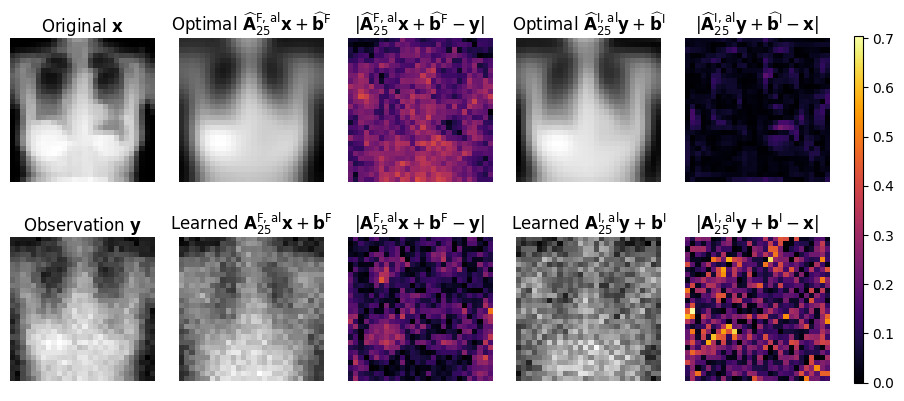

In [5]:
# --- Plotting ---
idx = 7181  # pick any example index

orig_img    = X_raw[idx].cpu()
y_img       = Y[:, idx].view(28, 28).cpu()
opt_img_f   = (M_r_f @ X + b_r_f)[:, idx].view(28, 28).cpu()
learn_img_f = (A_learned_f @ X + b_learned_f)[:, idx].view(28, 28).detach().cpu()
opt_img_i   = (M_r_i @ Y + b_r_i)[:, idx].view(28, 28).cpu()
learn_img_i = (A_learned_i @ Y + b_learned_i)[:, idx].view(28, 28).detach().cpu()

err_opt_f   = torch.abs(opt_img_f - y_img)
err_learn_f = torch.abs(learn_img_f - y_img)
err_opt_i   = torch.abs(opt_img_i - orig_img)
err_learn_i = torch.abs(learn_img_i - orig_img)

err_vmin, err_vmax = 0.0, max(
    err_opt_f.max(), err_learn_f.max(),
    err_opt_i.max(), err_learn_i.max()
).item()

fig = plt.figure(figsize=(11, 4.5))
gs  = gridspec.GridSpec(
    2, 6,
    width_ratios=[1, 1, 1, 1, 1, 0.06],
    wspace=0.20, hspace=0.35
)

# row 0 (forward optimal)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(orig_img, cmap='gray')
ax.set_title(r'Original $\mathbf{x}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 1])
ax.imshow(opt_img_f, cmap='gray')
ax.set_title(fr'Optimal $\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{F, al}}}} \mathbf{{x}} + \widehat{{\mathbf{{b}}}}^{{\text{{F}}}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(err_opt_f, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{F, al}}}} \mathbf{{x}} + \widehat{{\mathbf{{b}}}}^{{\text{{F}}}} - \mathbf{{y}}|$', pad=4)
ax.axis('off')

# row 0 (inverse optimal)
ax = fig.add_subplot(gs[0, 3])
ax.imshow(opt_img_i, cmap='gray')
ax.set_title(fr'Optimal $\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{I, al}}}} \mathbf{{y}} + \widehat{{\mathbf{{b}}}}^{{\text{{I}}}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 4])
ax.imshow(err_opt_i, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{I, al}}}} \mathbf{{y}} + \widehat{{\mathbf{{b}}}}^{{\text{{I}}}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# row 1 (forward learned)
ax = fig.add_subplot(gs[1, 0])
ax.imshow(y_img, cmap='gray')
ax.set_title(r'Observation $\mathbf{y}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 1])
ax.imshow(learn_img_f, cmap='gray')
ax.set_title(fr'Learned $\mathbf{{A}}_{{{r}}}^{{\text{{F, al}}}} \mathbf{{x}} + \mathbf{{b}}^{{\text{{F}}}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 2])
ax.imshow(err_learn_f, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\mathbf{{A}}_{{{r}}}^{{\text{{F, al}}}} \mathbf{{x}} + \mathbf{{b}}^{{\text{{F}}}} - \mathbf{{y}}|$', pad=4)
ax.axis('off')

# row 1 (inverse learned)
ax = fig.add_subplot(gs[1, 3])
ax.imshow(learn_img_i, cmap='gray')
ax.set_title(fr'Learned $\mathbf{{A}}_{{{r}}}^{{\text{{I, al}}}} \mathbf{{y}} + \mathbf{{b}}^{{\text{{I}}}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 4])
ax.imshow(err_learn_i, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\mathbf{{A}}_{{{r}}}^{{\text{{I, al}}}} \mathbf{{y}} + \mathbf{{b}}^{{\text{{I}}}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')


# Shared colorbar
cax = fig.add_subplot(gs[:, 5])
plt.colorbar(im, cax=cax)
cax.yaxis.tick_right()

plt.tight_layout()
plt.show()
